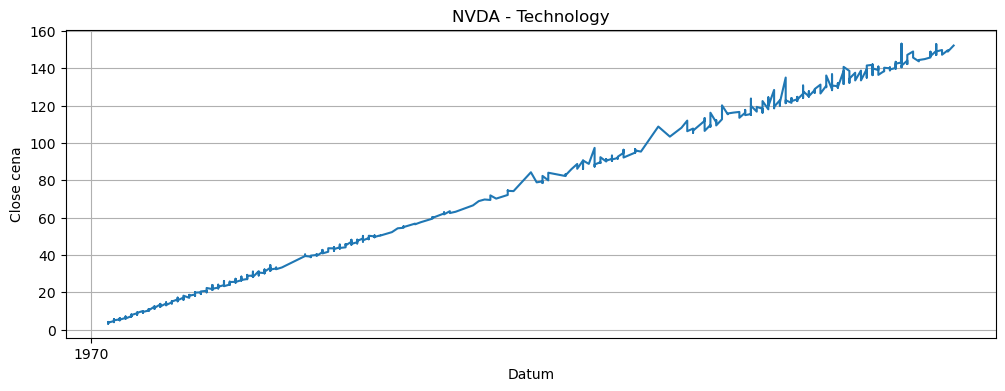

✅ Připraveno 18 datasetů pro modely.


In [4]:
# 📒 Notebook: 01_prepare_data.ipynb
# Tento notebook načítá historická data akcií z CSV, čistí je, normalizuje
# a připravuje vstupy pro LSTM modely.

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Přidání cesty ke složce se skripty
sys.path.append(os.path.abspath("../scripts"))
from utils import Normalizer, create_lstm_dataset

# Parametry okna a splitu
WINDOW_SIZE = 20
TRAIN_SPLIT = 0.8

# Cesta k datům
base_path = "../data/downloaded_stock_data"

# Načítání dat
sektory = os.listdir(base_path)
data_by_sector = {}

for sektor in sektory:
    sektor_path = os.path.join(base_path, sektor)
    if not os.path.isdir(sektor_path):
        continue

    data_by_sector[sektor] = {}
    for file in os.listdir(sektor_path):
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            path = os.path.join(sektor_path, file)
            try:
                df_raw = pd.read_csv(path, skiprows=3, header=None)
                df = df_raw[[1, 2]].copy()  # ✅ přidáno .copy() pro odstranění warningu
                df.columns = ["Date", "Close"]
                df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
                df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
                df = df.dropna().sort_values("Date")
                data_by_sector[sektor][ticker] = df
            except Exception as e:
                print(f"Chyba u {file}: {e}")

# Ukázka jednoho záznamu
sektor_ukazka = list(data_by_sector.keys())[0]
ticker_ukazka = list(data_by_sector[sektor_ukazka].keys())[0]
df_ukazka = data_by_sector[sektor_ukazka][ticker_ukazka]
df_ukazka.tail()

# Vizualizace
plt.figure(figsize=(12, 4))
plt.plot(df_ukazka['Date'], df_ukazka['Close'])
plt.title(f"{ticker_ukazka} - {sektor_ukazka}")
plt.xlabel("Datum")
plt.ylabel("Close cena")
plt.grid(True)
plt.show()

# Normalizace a vytvoření datasetu
vsechny_datasety = []

for sektor, tickery in data_by_sector.items():
    for ticker, df in tickery.items():
        ceny = df["Close"].values
        normalizer = Normalizer()
        normalizovane = normalizer.fit_transform(ceny)

        x, y = create_lstm_dataset(normalizovane, WINDOW_SIZE)
        split_idx = int(len(x) * TRAIN_SPLIT)

        vsechny_datasety.append({
            "sector": sektor,
            "ticker": ticker,
            "x_train": x[:split_idx],
            "y_train": y[:split_idx],
            "x_val": x[split_idx:],
            "y_val": y[split_idx:],
            "normalizer": normalizer,
            "original_df": df
        })

print(f"✅ Připraveno {len(vsechny_datasety)} datasetů pro modely.")